In [1]:
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay, ConvexHull
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
import copy
#import cartopy.crs as ccrs
#import cartopy


In [2]:
'''
Parameters
'''
radius = 1
res = 40
rho = 6.371e6
R = 1.496e11
alpha = 0/180*np.pi
beta = 60/180*np.pi

sigma = 0.01
nwater = 1.33
epsilon = 0.000000001

day = 24 
year = 365*day
omega_day =  2*np.pi/day 
omega_year = 2*np.pi/year


delta_t = 1
delta_phi = np.pi/res
delta_theta = np.pi/res
delta_Omega = delta_phi*delta_theta 

hours = np.arange(0, 24)
time_array = hours.copy()

N_ave = 187

for i in range(1, 365):
    time_array = np.append(time_array, hours + i*year/365)

time_res = len(time_array)

In [3]:
def format_func(value, tick_number):
    # find number of multiples of pi/6
    N = int(np.round(6 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/6$"
    elif N == 2:
        return r"$\pi/3$"
    elif N == 3:
        return r"$\pi/2$"
    elif N == 4:
        return r"$2\pi/3$"
    elif N == 5:
        return r"$5\pi/6$"
    elif N == 6:
        return r"$\pi$"
    elif N % 6 > 0:
        if N % 3 == 0:
            return r"${0}\pi/2$".format(N // 3)
        if N%2 ==0: 
            return r"${0}\pi/3$".format(N // 2)
        else:
            
            return r"${0}\pi/6$".format(N)
    else:
        return r"${0}\pi$".format(N // 6)

In [4]:
def create_sphere1(r, res):
    '''
    creates points on a sphere in the form:
        [[ x1.  y1.  z1.]
         ....
         [ xn.  yn.  zn.]]
    '''
    phi = np.linspace(0, 2*np.pi, 2*res)
    theta = np.linspace(0, np.pi, res)

    theta, phi = np.meshgrid(theta, phi)  
    
    theta_flat = np.ndarray.flatten(theta, order = 'C')
    phi_flat = np.ndarray.flatten(phi, order = 'C')
    
    r_pre = r*np.sin(theta_flat)
    x = np.cos(phi_flat)*r_pre
    y = np.sin(phi_flat)*r_pre
    z = r*np.cos(theta_flat)

    ''' 
    flatten arrays, delete top- end bottom points of circle and append both points once
    '''
#    x = np.delete(x, [0, res-1], 1)
#    x = np.ndarray.flatten(x, order ='F') 
#    x = np.append(x, [0,0])
#    y = np.delete(y, [0, res-1], 1)
#    y = np.ndarray.flatten(y, order = 'F') 
#    y= np.append(y, [0,0])
#    z = np.delete(z, [0, res-1], 1)
#    z = np.ndarray.flatten(z, order = 'F') 
#    z= np.append(z, [1,-1])
    

    coordinates = np.vstack((x,y,z)).transpose()

    return coordinates, theta, phi





def pnt_in_cvex_hull(hull, pnt):
    '''
    Checks if `pnt` is inside the convex hull.
    '''
    new_hull = ConvexHull(np.concatenate((hull.points, [pnt])))
    if np.array_equal(new_hull.vertices, hull.vertices): 
        return True
    else:
        return False




def height(p, vertices, seeds, altitudes):
    max_dist = 0
    '''
    finding shortest edge
    '''
    for i in range(3):
        for j in range(i+1 , 4):
            dist = np.linalg.norm(vertices[i] - vertices[j])
            if dist > max_dist:
                max_dist = dist
                furthest = np.array([i, j])   
   
    '''
    reordering everything
    '''          
    vertices[[0, furthest[0]]] = vertices[[furthest[0], 0]]
    vertices[[1, furthest[1]]] = vertices[[furthest[1], 1]]
    
    seeds[[0,furthest[0]]] = seeds[[furthest[0], 0]]
    seeds[[1,furthest[1]]] = seeds[[furthest[1], 1]]
    
    altitudes[[0, furthest[0]]] = altitudes[[furthest[0], 0]]
    altitudes[[1, furthest[1]]] = altitudes[[furthest[1], 1]]
    
    '''
    creating new edge
    new altitude = average altitude + random(-0,05; 0,05)*sqrt(distance)
    '''
    v_new = (vertices[0]+vertices[1])/2
    s_new = (seeds[0]+seeds[1])/2
    random.seed(s_new)
    a_new = (altitudes[0]+ altitudes[1])/2 + 0.01*(random.random()- 0.5)*max_dist**1.5

    
    '''
    finding in which tetrahedon our point p is
    '''    
    tetra = np.copy(vertices)
    tetra[1] = v_new
    hull = ConvexHull(tetra)
    
    if pnt_in_cvex_hull(hull, p):
        vertices[1] = v_new
        seeds[1] = s_new
        altitudes[1] = a_new
    else:
        vertices[0] = v_new
        seeds[0] = s_new
        altitudes[0] = a_new 
    
    '''
    stop if resolution is great enough
    '''
    if max_dist < 0.001:
#        print(np.sum(altitudes)/4)
        return np.sum(altitudes)/4
    else:
#        print(vertices)
#        print(seeds)
#        print(altitudes)
        
        height(p, vertices, seeds, altitudes)
    return np.sum(altitudes)/4

def polar(polarcaps, sphere,alts, p_ice):
    minz = min(sphere[:,2])
    maxz = max(sphere[:,2])
    rowdivide = np.linspace(minz,maxz,100)
    rangez = abs(maxz - minz)
    
    iceval = max(alts)
    
    for i in range(len(alts)):
        if abs(maxz-sphere[i,2])/rangez < p_ice or abs(minz-sphere[i,2])/rangez < p_ice:
            alts[i] = iceval
    return alts


In [5]:
sphere, theta, phi = create_sphere1(1, res)

In [6]:
filename = 'V2Reflectivities_planet'+str(4)+'_res'+str(res)+'.npz'
loaded  = np.load(filename)

albedo_map = loaded['lamb']
onlylamb_map = loaded['onlylamb']
ocean_map = loaded['glint']
seeliger_map = loaded['seel']
alts1 = loaded['alts']
albedo_pseudo = loaded['pseudo']

alt_grid_height = alts1.reshape((2*res,res), order = 'C')

albedo_pseudo_grid = albedo_pseudo.reshape((res,2*res), order = 'F')


albedo_map_grid = albedo_map.reshape((res, 2*res), order = 'F')
onlylamb_map_grid = onlylamb_map.reshape((res,2*res), order= 'F')
ocean_map_grid = ocean_map.reshape((res,2*res), order = 'F')
seeliger_map_grid = seeliger_map.reshape((res,2*res), order= 'F')

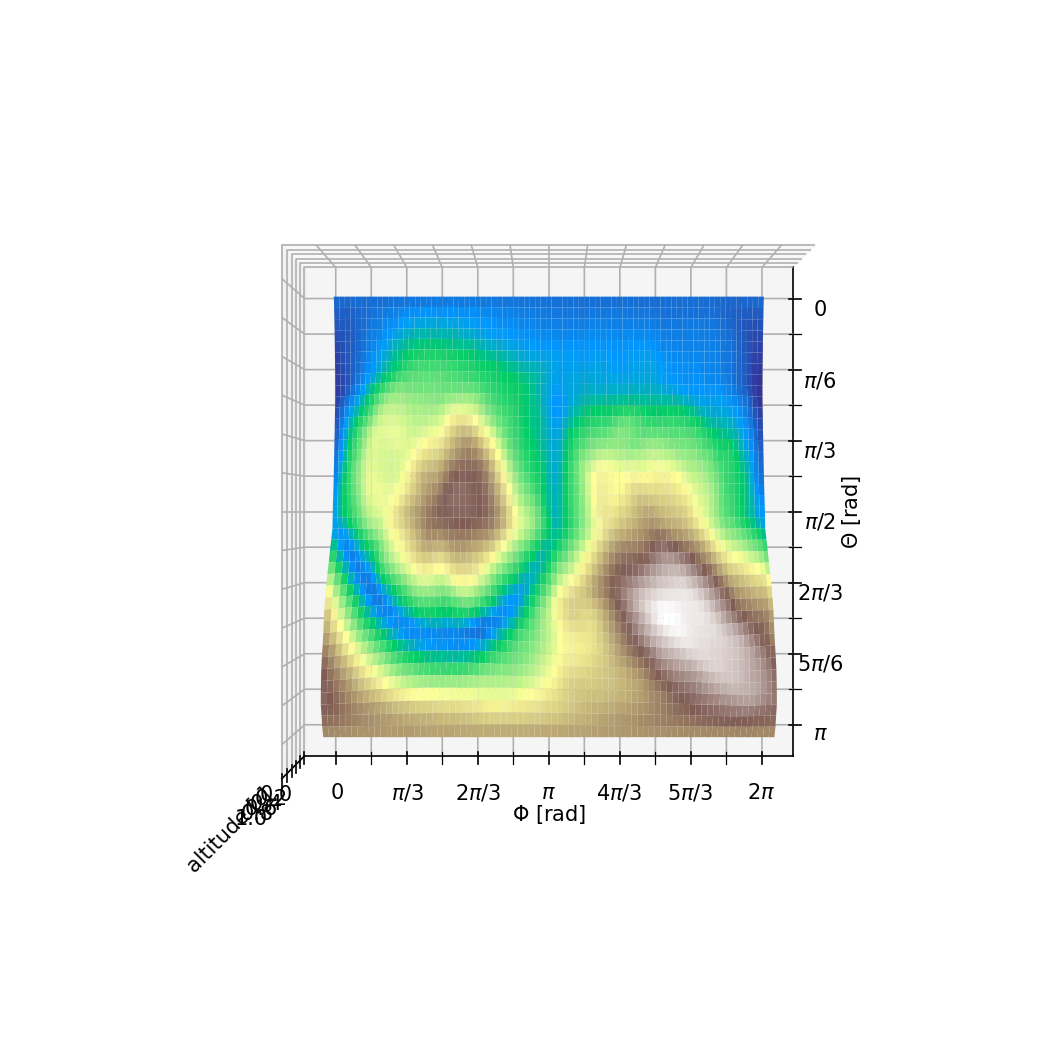

In [11]:
'''
height map
'''
%matplotlib widget
fig = plt.figure(figsize=(7,7),dpi=150)
ax = plt.axes(projection='3d')
surf = ax.plot_surface(theta,phi, alt_grid_height, rstride=1, cstride=1, cmap='terrain', edgecolor='none')
ax.set_xlabel('$\Theta$ [rad]')
ax.set_ylabel('$\Phi$ [rad]')
ax.set_zlabel('altitude [-]')
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 6))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 3))
ax.yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 6))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
#fig.colorbar(surf, shrink=0.6, aspect=30,orientation = 'horizontal', location = 'top')
ax.view_init(90, 0)
             
plt.show()


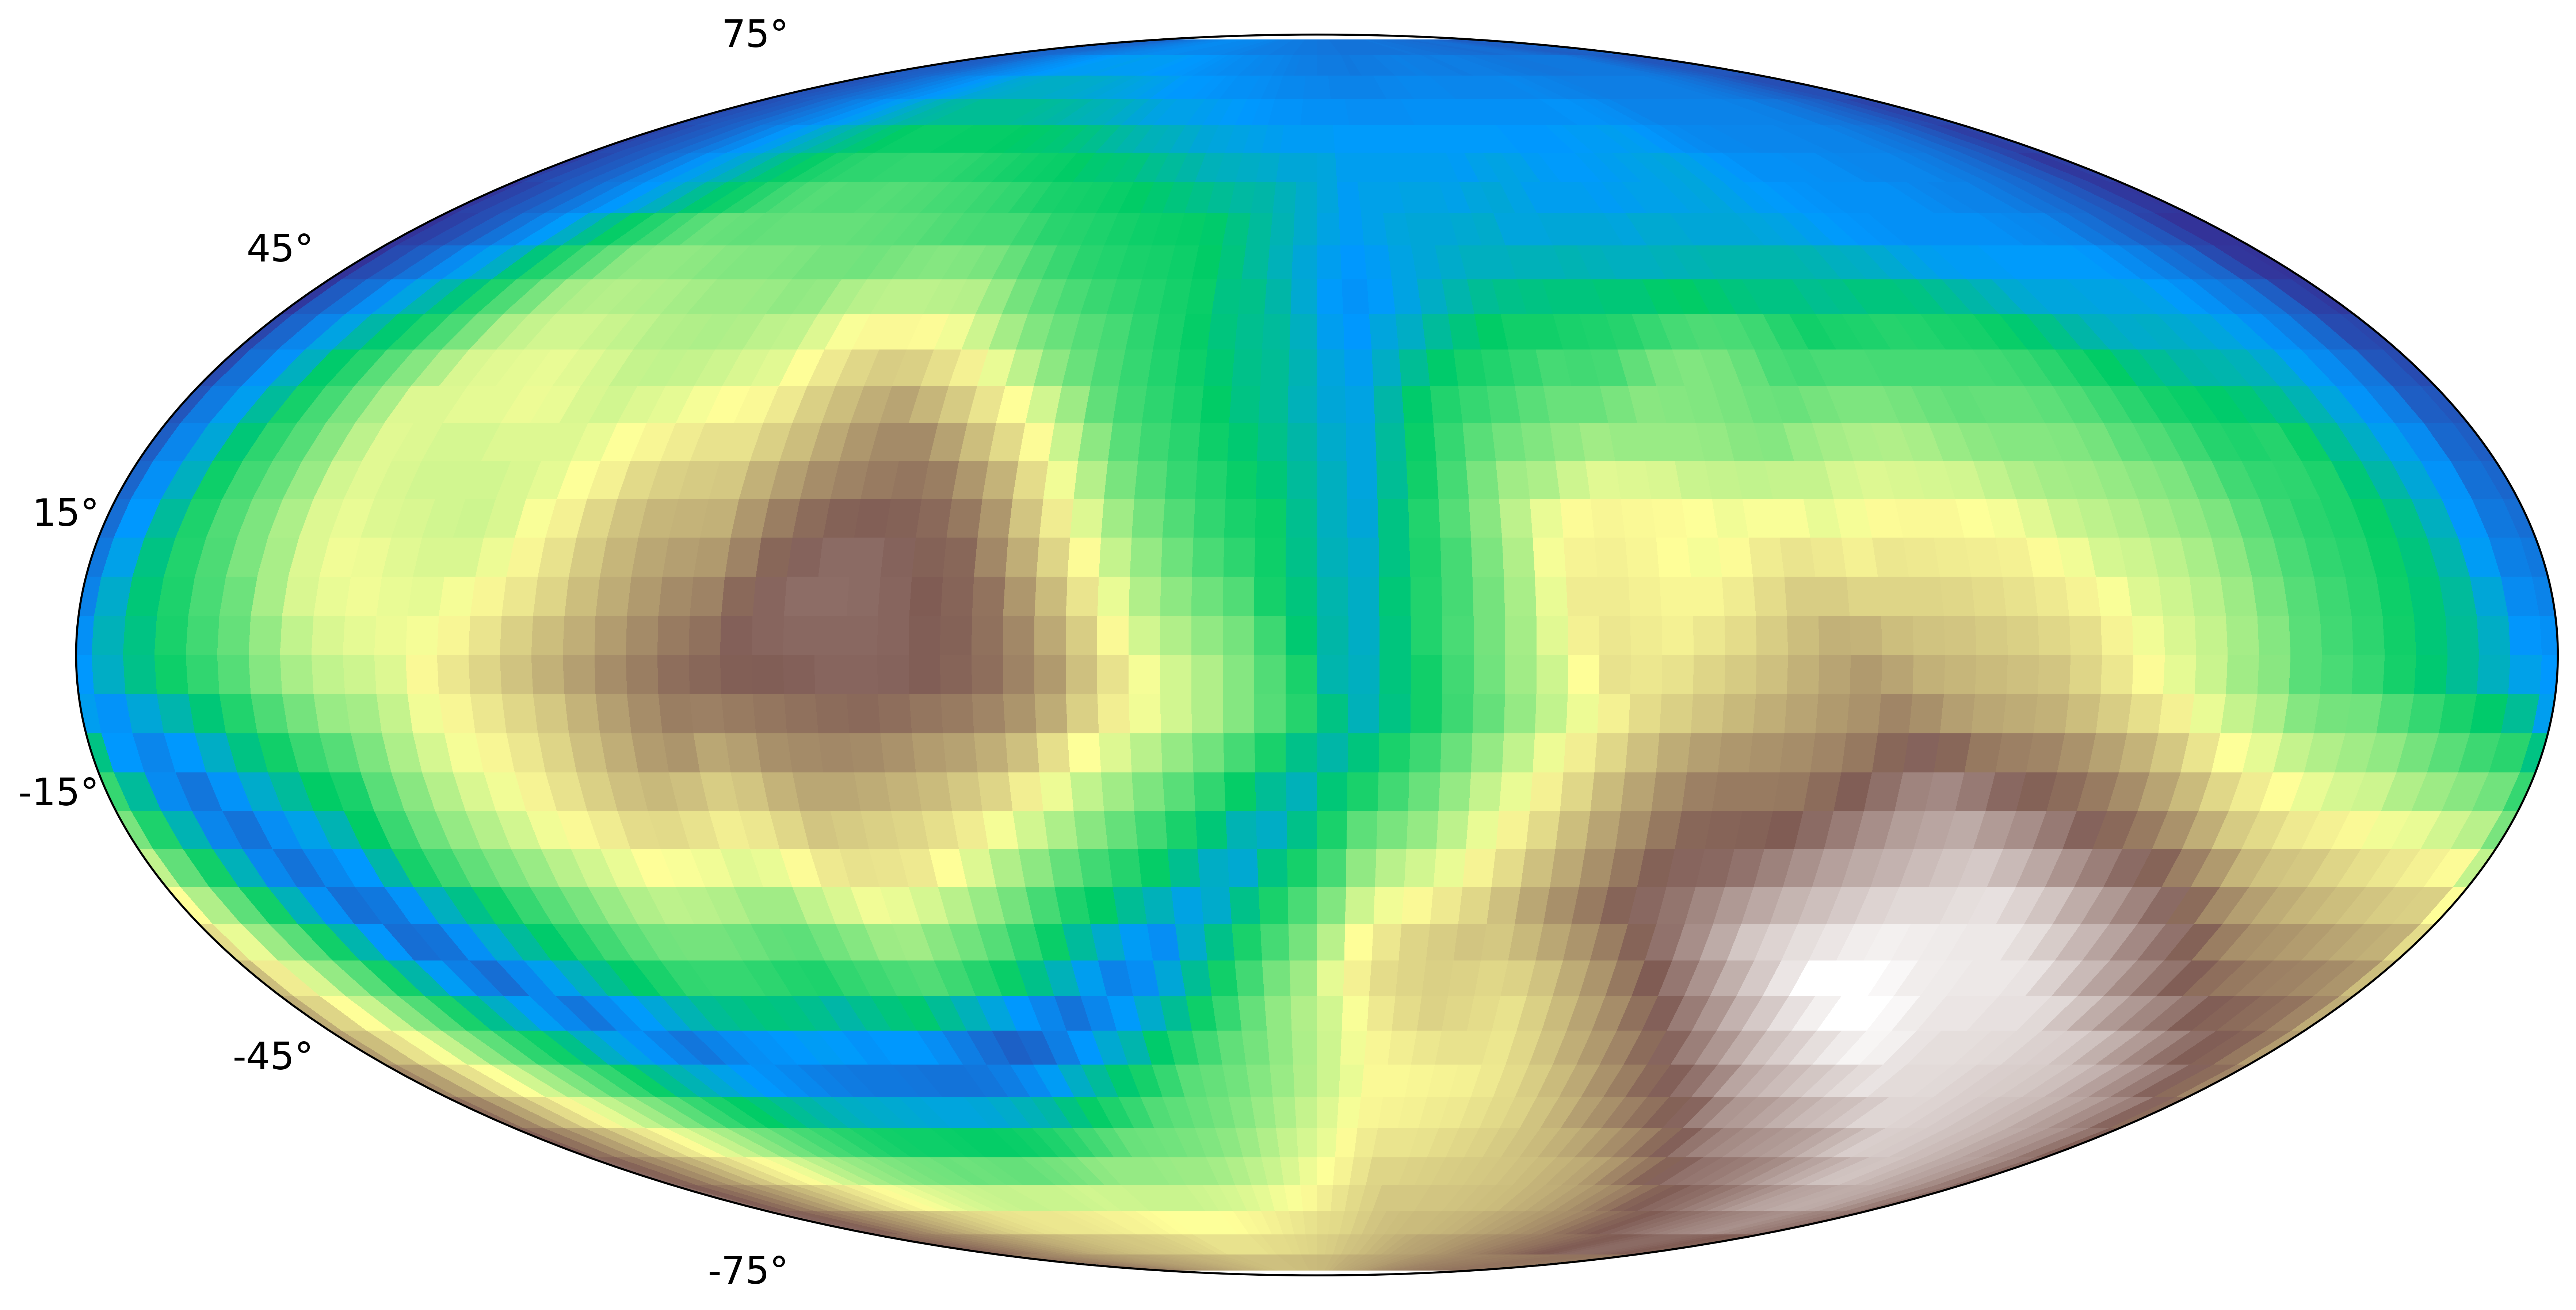

In [8]:
%matplotlib inline
alt_grid = alts1.reshape((res, 2*res), order = 'F')
albedo_map_grid = albedo_map.reshape((res, 2*res), order = 'F')
albedo_pseudo_grid = albedo_pseudo.reshape((res,2*res), order = 'F')


newgistearth = cm.get_cmap('gist_earth', 4096)
newcolors = np.vstack((newgistearth(np.linspace(0,0.35,256)), newgistearth(np.linspace(0.45,1,256))))
newcmp = ListedColormap(newcolors)

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,9), dpi= 500)
ax1 = fig1.add_subplot(111, projection = 'mollweide')
im1 = ax1.pcolormesh(Lon,Lat, np.flipud(alt_grid),cmap = 'terrain')
#plt.colorbar(im1,shrink = 0.6, aspect=40, ax = ax1, orientation = 'horizontal', location = 'top')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '20')
ax1.set_yticklabels(tick_labels_y, fontsize = '15')

plt.show()

busy plotting


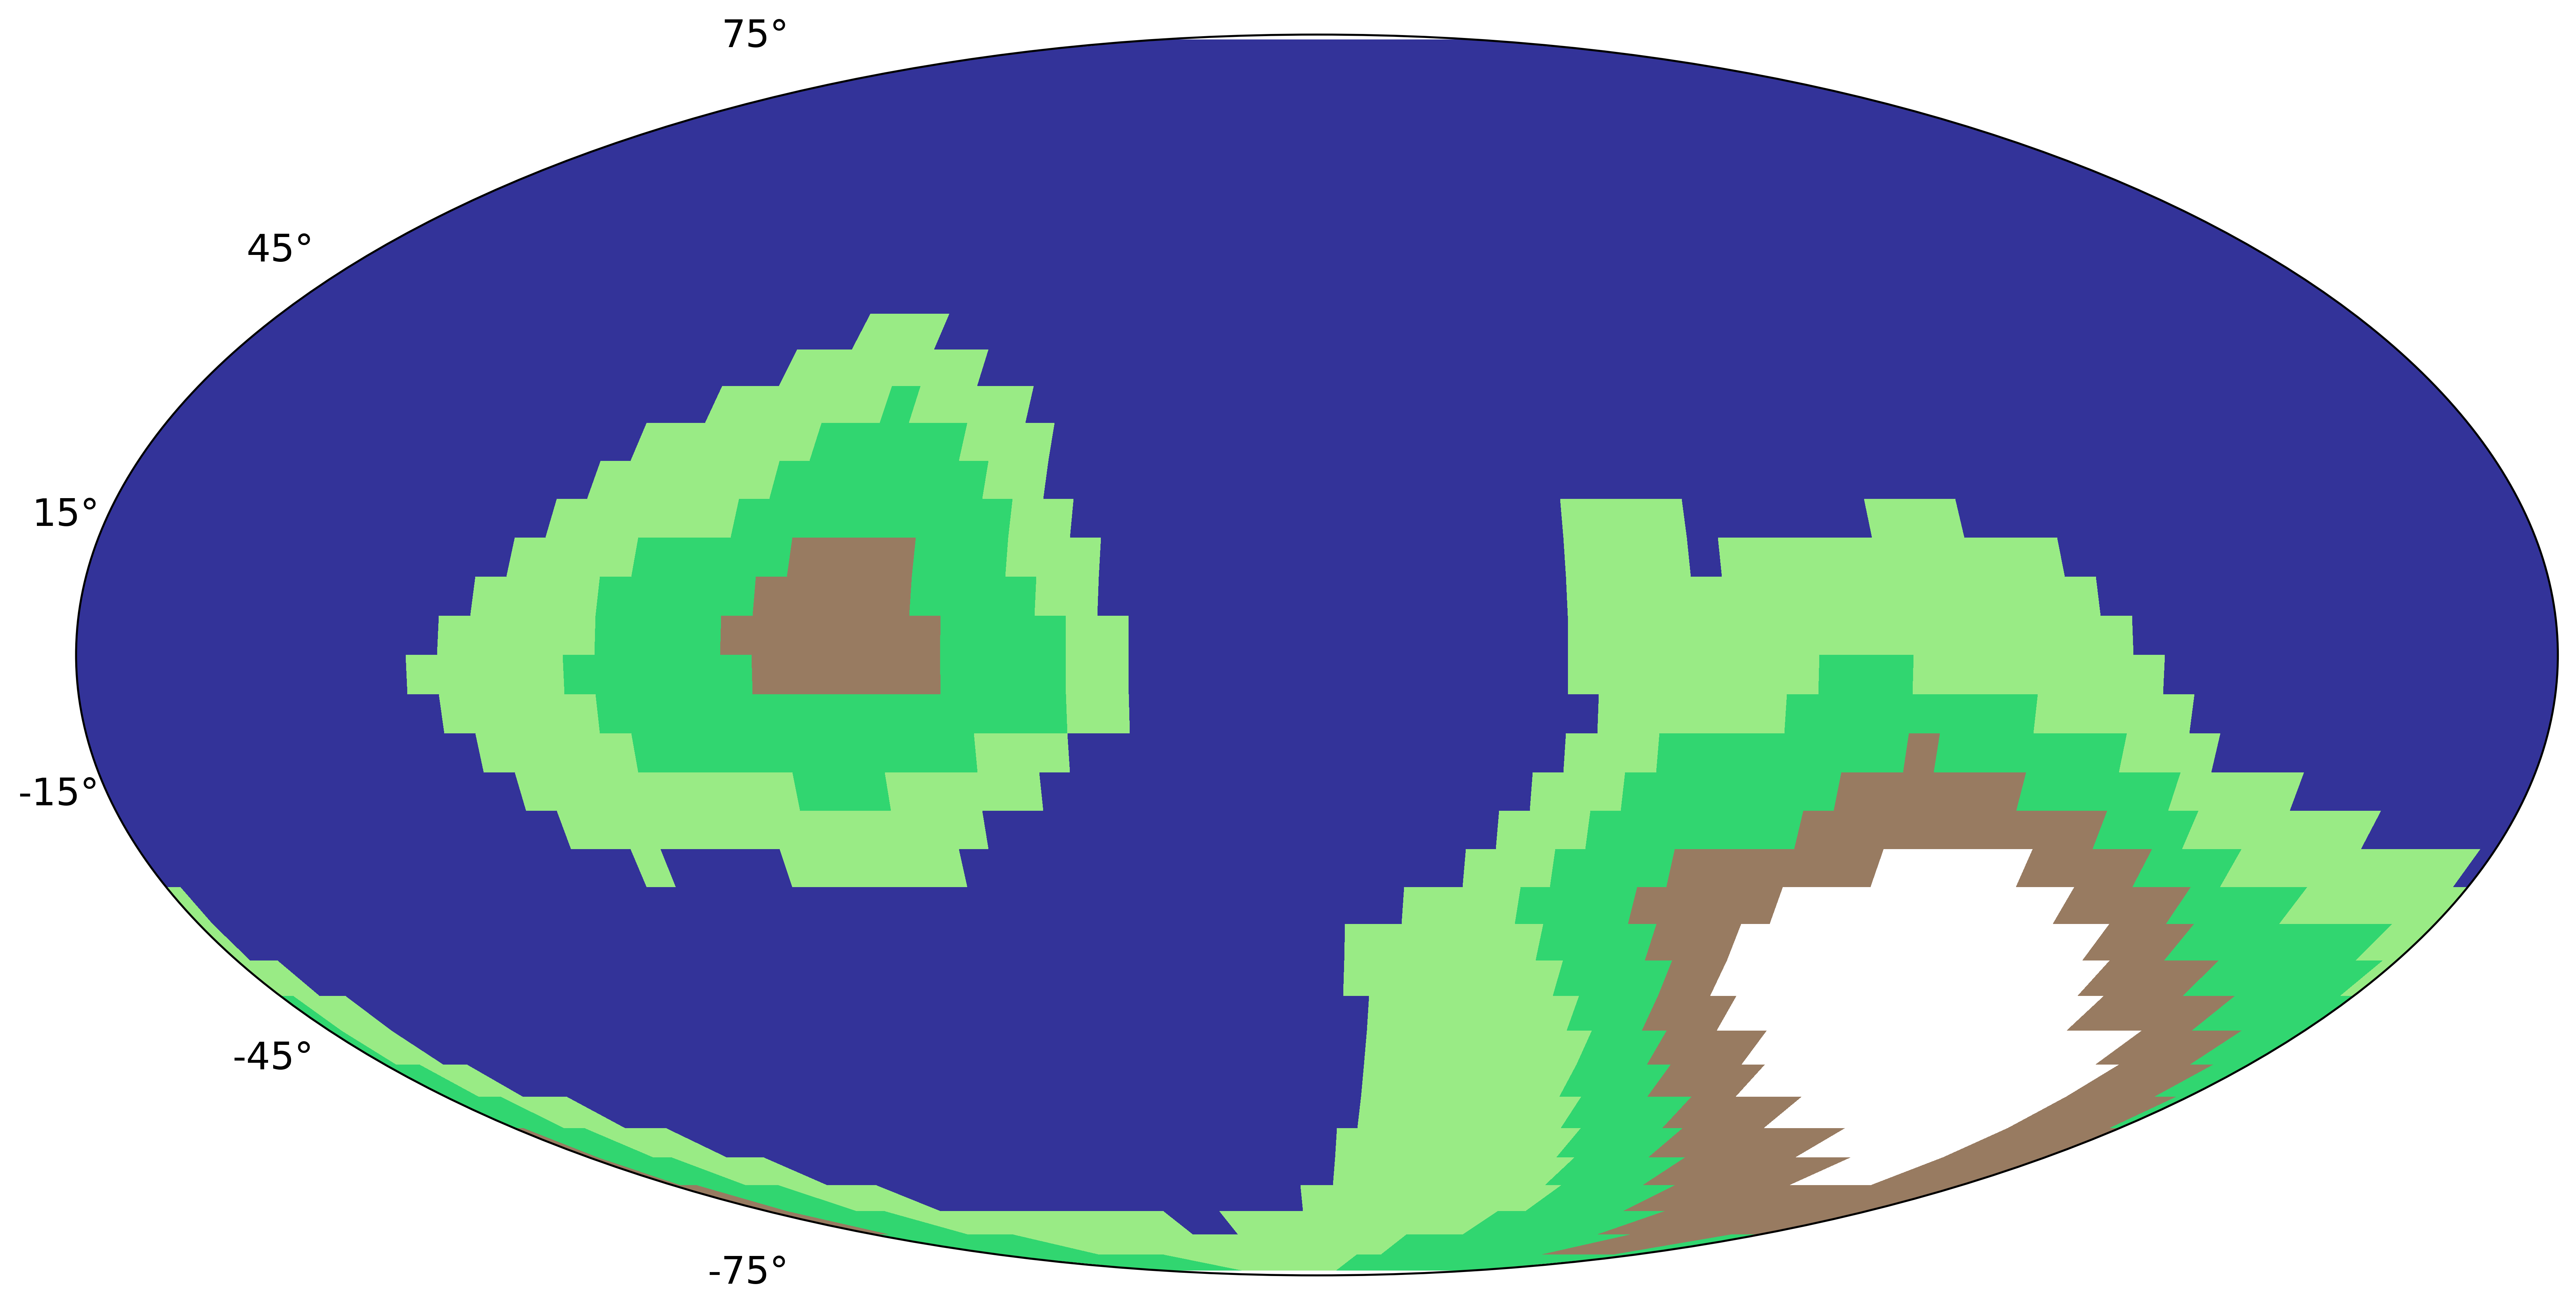

In [9]:
print('busy plotting')
'''
create corresponding meshgrid
'''
%matplotlib inline
newgistearth = cm.get_cmap('gist_earth', 4096)
newcolors = np.vstack((newgistearth(np.linspace(0,0.35,256)), newgistearth(np.linspace(0.45,1,256))))
newcmp = ListedColormap(newcolors)

albedo_colors = np.vstack((newgistearth(np.linspace(0.15,0.22,100)), newgistearth(np.linspace(0.45,0.55,200)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,200)), newgistearth(np.linspace(0.95,1,400))))
albedo_cmp = ListedColormap(albedo_colors)
albedo_colors1 = np.vstack((newgistearth(np.linspace(0.1,0.22,100)), newgistearth(np.linspace(0.25,0.55,100)),newgistearth(np.linspace(0.6,0.7,400)),newgistearth(np.linspace(0.7,0.8,100)), newgistearth(np.linspace(0.95,1,100))))
albedo_cmp1 = ListedColormap(albedo_colors1)

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,9), dpi =500)
ax1 = fig1.add_subplot(111, projection = 'mollweide')
im1 = ax1.pcolormesh(Lon,Lat, np.flipud(albedo_pseudo_grid),cmap = 'terrain')
#plt.colorbar(im1,shrink = 0.75, aspect=40)
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '20')
ax1.set_yticklabels(tick_labels_y, fontsize = '15')
plt.show()

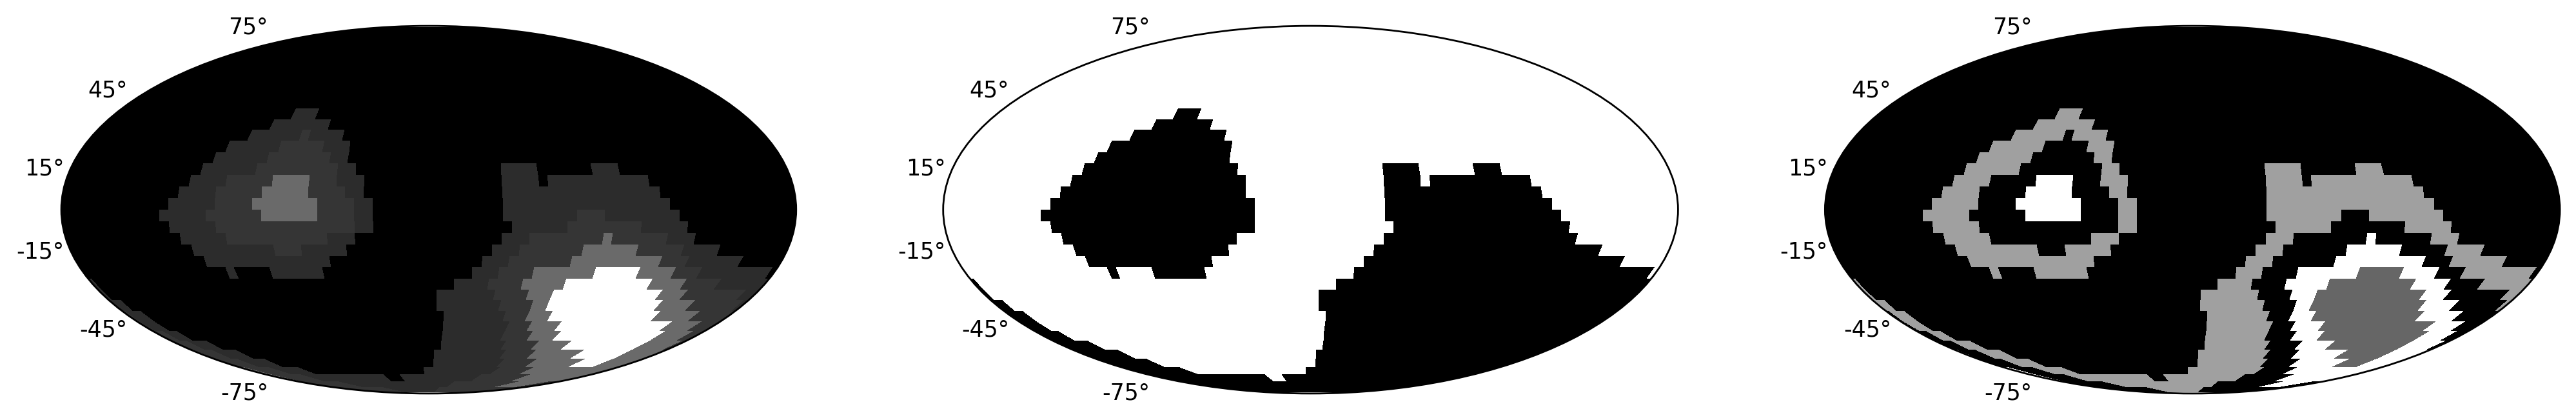

In [10]:
#plot albedo specular and seeliger maps together

%matplotlib inline


shrink = 0.9

newgistearth = cm.get_cmap('gist_earth', 4096)
newcolors = np.vstack((newgistearth(np.linspace(0,0.35,256)), newgistearth(np.linspace(0.45,1,256))))
newcmp = ListedColormap(newcolors)

albedo_colors = np.vstack((newgistearth(np.linspace(0.15,0.22,100)), newgistearth(np.linspace(0.45,0.55,200)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,200)), newgistearth(np.linspace(0.95,1,400))))
albedo_cmp = ListedColormap(albedo_colors)
albedo_colors1 = np.vstack((newgistearth(np.linspace(0.15,0.22,140)), newgistearth(np.linspace(0.45,0.55,180)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,280)), newgistearth(np.linspace(0.95,1,400))))
albedo_cmp1 = ListedColormap(albedo_colors1)

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,4), dpi = 250)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')


im1 = ax1.pcolormesh(Lon,Lat, np.flipud(albedo_map_grid),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=30, ax = ax1, orientation = 'horizontal', location = 'top')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(ocean_map_grid),cmap = 'gray')
#plt.colorbar(im2,shrink = shrink, aspect=30, ax = ax2, orientation = 'horizontal', location = 'top')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(seeliger_map_grid),cmap = 'gray')
#plt.colorbar(im3,shrink = shrink, aspect=30, ax = ax3, orientation = 'horizontal', location = 'top')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')
                   
                                         
             
plt.show()
